Preparación del entorno

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from envs.multi_step_attack_env import AttackEnvMultiStep
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import numpy as np
import joblib
from stable_baselines3 import SAC


Funciones Auxiliares

In [ ]:
# Clase callback personalizada para logear y graficar
class AttackLoggerCallback(BaseCallback): # Extiende BaseCallback de stable-baselines3

    def __init__(self, log_freq: int = 1000, verbose: int = 0): # Muestra estadísticas cada 1000 episodios y pone el nivel de verbosidad a 0 por defecto (no muestra nada)
        super().__init__(verbose) # Llamamos al constructor padre con el nivel de verbosidad
        self.log_freq = log_freq # Muestra estadísticas cada log_freq episodios
        self.episode_count = 0 # Contador de episodios completados

        # Buffers por ventana (1000 episodios)
        self.rewards_buffer = [] # Buffer para recompensas
        self.success_buffer = [] # Buffer de veces que tuvo éxito
        self.p_attack_buffer = [] # Buffer de probabilidades de que el detector detecte el ataque

        # Históricos completos para graficar
        self.history_episodes = []
        self.history_mean_reward = []
        self.history_success_rate = []
        self.history_mean_p_attack = []

    def _on_step(self) -> bool:

        # Extraemos la información relevante del entorno
        infos = self.locals["infos"] # Información devuelta por el entorno
        rewards = self.locals["rewards"] # Recompensas obtenidas
        dones = self.locals["dones"] # Si el episodio ha terminado

        # Iteramos sobre la información, recompensas y estados de finalización
        for info, r, done in zip(infos, rewards, dones):

            # Si el episodio ha terminado
            if done:
                self.episode_count += 1 #  Incrementamos el contador de episodios
                self.rewards_buffer.append(float(r)) # Guardamos la recompensa obtenida

                # Si hubo éxito en el ataque
                if "success" in info:
                    self.success_buffer.append(int(info["success"])) # Guardamos si tuvo éxito

                # Si se proporciona la probabilidad de detección del ataque
                if "p_attack" in info:
                    self.p_attack_buffer.append(float(info["p_attack"])) # Guardamos la probabilidad de detección del ataque

                # Cada log_freq episodios, mostramos las estadísticas
                if self.episode_count > 0 and self.episode_count % self.log_freq == 0:

                    # Calculamos las métricas
                    mean_reward = np.mean(self.rewards_buffer) if self.rewards_buffer else 0.0 # Recompensa media
                    success_rate = np.mean(self.success_buffer) if self.success_buffer else 0.0 # Tasa de éxito
                    mean_p_attack = np.mean(self.p_attack_buffer) if self.p_attack_buffer else 0.0 # Probabilidad media de detección del ataque

                    # Guardamos las métricas en el histórico
                    self.history_episodes.append(self.episode_count) # Episodios completados
                    self.history_mean_reward.append(mean_reward) # Recompensa media
                    self.history_success_rate.append(success_rate) # Tasa de éxito
                    self.history_mean_p_attack.append(mean_p_attack) # Probabilidad media de detección del ataque

                    # Mostramos las métricas por consola
                    print(
                        f"[AttackLogger] Episodios: {self.episode_count:6d} | "
                        f"Reward medio: {mean_reward: .3f} | "
                        f"Tasa éxito: {success_rate*100:5.1f}% | "
                        f"p_attack media: {mean_p_attack: .3f}"
                    )

                    # Limpiamos los buffers para la siguiente ventana
                    self.rewards_buffer.clear()
                    self.success_buffer.clear()
                    self.p_attack_buffer.clear()

        return True

Creación del área de trabajo

In [3]:
# Carga del dataset
data = np.load("../data/synthetic_2d.npz")
X_train, X_test = data["X_train"], data["X_test"]
y_train, y_test = data["y_train"], data["y_test"]

# Cargamos solo muestras de ataque para el entorno
attack_mask = y_train == 1 # Crea un array booleano a true para muestras de ataque
attack_samples = X_train[attack_mask] # Nos quedamos solo con las muestras de ataque

# Carga del modelo clasificador
clf = joblib.load("../classifiers/logreg_synthetic_2d.joblib")

# Imprimimos la forma de las muestras de ataque
print("Attack samples:", attack_samples.shape)


Attack samples: (800, 2)


In [ ]:
# Función para crear el entorno
def make_env():
    return AttackEnvMultiStep(
        attack_samples=attack_samples, # Lista de todas las muestras de ataque
        clf=clf, # Modelo clasificador
        threshold=0.5, # A partid de de esta probabilidad se considera que es ataque
        epsilon=0.7,   # Distancia máxima que el agente puede mofificar el punto original, aumentamos un poco
        penalty=0.01,  # Penalización suave por tamaño de la perturbación
        max_steps=5,   # 5 movimientos por ataque
    )

# Creamos el entorno vectorizado
venv = DummyVecEnv([make_env])

# Normalizamos las observaciones del entorno    
venv = VecNormalize(venv, norm_obs=True, norm_reward=False) # SAC trabaja mejor con observaciones normalizadas (entre 0 y 1)

Entrenamiento del agente SAC

In [15]:
# Architectura de la red neuronal del actor y crítico
policy_kwargs = dict(net_arch=[256, 256])

model = SAC(
    "MlpPolicy",
    venv, # Entorno vectorizado y normalizado
    verbose=0, # No muestra información durante el entrenamiento
    policy_kwargs=policy_kwargs, # Arquitectura de la red neuronal
    buffer_size=200_000, 
    learning_rate=3e-4, # Tasa de aprendizaje, qué tanto se actualizan los pesos de la red neuronal en cada paso
    batch_size=256, # Los grupos en los que se divide cada actualización
    tau=0.02,
    train_freq=1,
    gradient_steps=1,
)

# Creación del callback personalizado para logging
callback = AttackLoggerCallback(log_freq=100)

# Entrenamiento del agente SAC con 10,000 timesteps y el callback
model.learn(total_timesteps=10_000, callback=callback)

# Guardamos el modelo entrenado y el entorno normalizado
model.save("../agents/sac_attacker_multistep")
venv.save("../agents/sac_attacker_multistep_vecnorm.pkl") #¿?

[AttackLogger] Episodios:    100 | Reward medio:  0.022 | Tasa éxito:   3.0% | p_attack media:  0.954
[AttackLogger] Episodios:    200 | Reward medio:  0.478 | Tasa éxito:  39.0% | p_attack media:  0.625
[AttackLogger] Episodios:    300 | Reward medio:  0.893 | Tasa éxito:  79.0% | p_attack media:  0.219
[AttackLogger] Episodios:    400 | Reward medio:  1.061 | Tasa éxito:  95.0% | p_attack media:  0.053
[AttackLogger] Episodios:    500 | Reward medio:  1.048 | Tasa éxito: 100.0% | p_attack media:  0.009
[AttackLogger] Episodios:    600 | Reward medio:  1.024 | Tasa éxito: 100.0% | p_attack media:  0.003
[AttackLogger] Episodios:    700 | Reward medio:  1.016 | Tasa éxito: 100.0% | p_attack media:  0.001
[AttackLogger] Episodios:    800 | Reward medio:  1.014 | Tasa éxito: 100.0% | p_attack media:  0.001
[AttackLogger] Episodios:    900 | Reward medio:  1.012 | Tasa éxito: 100.0% | p_attack media:  0.001
[AttackLogger] Episodios:   1000 | Reward medio:  1.016 | Tasa éxito: 100.0% | p_a

Gráficas

In [34]:
# Configuración de gráficos para visualizar los resultados
plt.style.use("seaborn-v0_8-whitegrid")

# Datos para graficar
episodes = np.array(callback.history_episodes)
success_rate = np.array(callback.history_success_rate) * 100
mean_reward = np.array(callback.history_mean_reward)
mean_p_attack = np.array(callback.history_mean_p_attack)

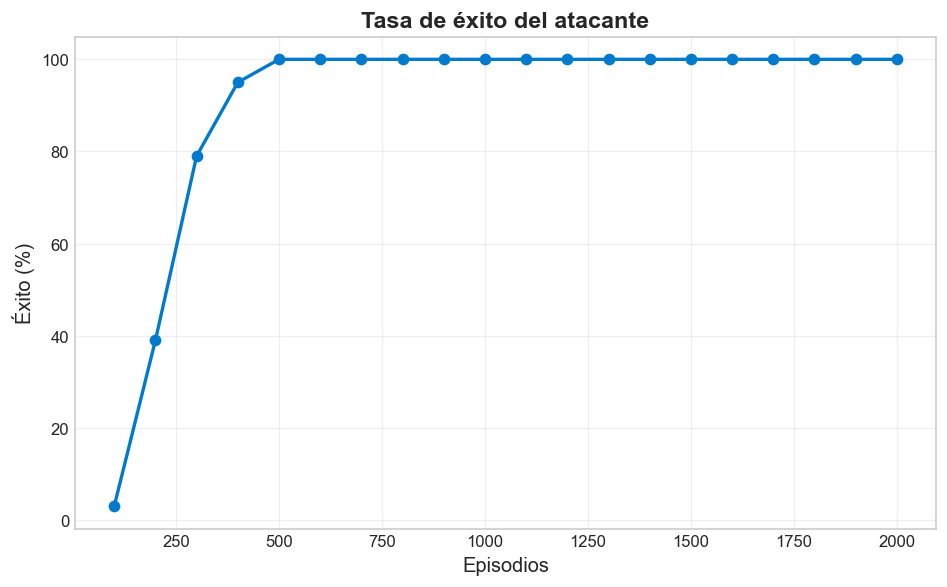

In [35]:
# Grafico de Tasa de éxito
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(
    episodes,
    success_rate,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#007acc",
)
plt.title("Tasa de éxito del atacante", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("Éxito (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

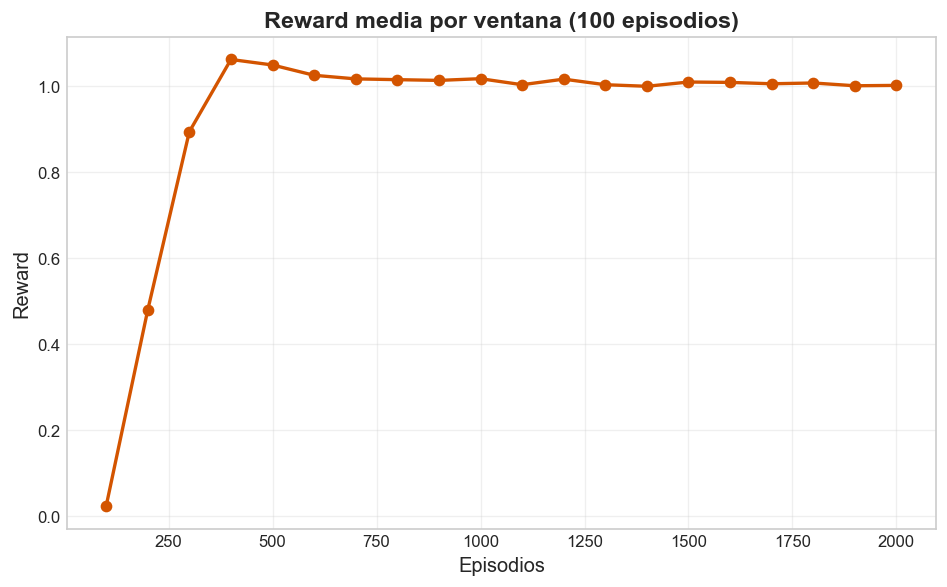

In [36]:
# Grafico de Reward media por vetana (100 episodios)
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(
    episodes,
    mean_reward,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#d35400",
)
plt.title("Reward media por ventana (100 episodios)", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

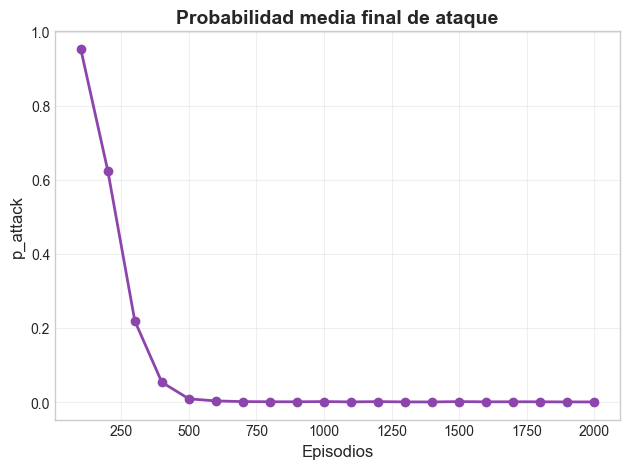

In [37]:
# Grafico de Probabilidad media final de ataque
plt.plot(
    episodes,
    mean_p_attack,
    marker="o",
    linewidth=2,
    markersize=6,
    color="#8e44ad",
)

plt.title("Probabilidad media final de ataque", fontsize=14, fontweight="bold")
plt.xlabel("Episodios", fontsize=12)
plt.ylabel("p_attack", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Evaluación

In [7]:
# Recargamos entorno y normalización
eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize.load("../agents/sac_attacker_multistep_vecnorm.pkl", eval_env)
eval_env.training = False
eval_env.norm_reward = False

model = SAC.load("../agents/sac_attacker_multistep")

In [8]:
def evaluate_sac_attacker(model, env, n_episodes=500):
    successes = 0
    total_steps = 0
    final_p_attacks = []

    obs = env.reset()
    for _ in range(n_episodes):
        done = False
        truncated = False
        # Gymnasium+VecEnv: done = terminated or truncated
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            # info es una lista de diccionarios (para cada env); usamos el primero
            info0 = info[0]
            truncated = info0.get("terminal_observation") is not None if False else False  # parche si hace falta

            total_steps += 1
            # Si estamos en el último paso del episodio (max_steps)
            if info0.get("step_count", 0) == env.get_attr("max_steps")[0]:
                # evasión si pred == 0
                if info0["pred"] == 0:
                    successes += 1
                final_p_attacks.append(info0["p_attack"])

        obs = env.reset()

    success_rate = successes / n_episodes
    mean_final_p = float(np.mean(final_p_attacks)) if final_p_attacks else None
    return success_rate, mean_final_p

success_rate, mean_final_p = evaluate_sac_attacker(model, eval_env, n_episodes=300)
print(f"Tasa de evasión (episodio completo): {success_rate:.3f}")
print(f"Probabilidad media final de ataque: {mean_final_p:.3f}")

Tasa de evasión (episodio completo): 1.000
Probabilidad media final de ataque: 0.001
